In [213]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import numpy as np

In [214]:
def notify(title, text):
    os.system("""
              osascript -e 'display notification "{}" with title "{}"'
              """.format(text, title))

In [215]:
rawWhitesDF = pd.read_csv("raw-wine-data/winequality-white.csv", delimiter=";")
rawRedsDF = pd.read_csv("raw-wine-data/winequality-red.csv", delimiter=";")

In [216]:
rawWhitesDF.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [217]:
featureLabels = list(rawWhitesDF.columns.values)
classes = [c for c in range(1, 11)]

# Normalising the continuous data with MinMax scaling
scaledWhitesDF = rawWhitesDF.copy()
scaledRedsDF = rawRedsDF.copy()

for column in featureLabels[:-1]:
    scaledWhitesDF[column] = (scaledWhitesDF[column] - scaledWhitesDF[column].min()) / (scaledWhitesDF[column].max() - scaledWhitesDF[column].min())
    scaledRedsDF[column] = (scaledRedsDF[column] - scaledRedsDF[column].min()) / (scaledRedsDF[column].max() - scaledRedsDF[column].min())

In [218]:
whiteTargetsInt = torch.tensor(scaledWhitesDF['quality'].to_numpy())
whiteFeatures = torch.tensor(scaledWhitesDF[featureLabels[0:-1]].to_numpy(), requires_grad=True, dtype=torch.float32)

redTargetsInt = torch.tensor(scaledRedsDF['quality'].to_numpy())
redFeatures = torch.tensor(scaledRedsDF[featureLabels[0:-1]].to_numpy(), requires_grad=True, dtype=torch.float32)

In [219]:
whiteTargets =  []

for i, target in enumerate(whiteTargetsInt):
    embed = torch.zeros(len(classes), dtype=torch.float32)
    embed[target.item()-1] = 1
    whiteTargets.append(embed)
whiteTargets = torch.stack(whiteTargets).to(torch.float32)

redTargets = []

for i, target in enumerate(redTargetsInt):
    embed = torch.zeros(len(classes), dtype=torch.float32)
    embed[target.item()-1] = 1
    redTargets.append(embed)
redTargets = torch.stack(redTargets).to(torch.float32)

In [220]:
class WineDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        sample = {
            'features': self.features[idx],
            'target': self.targets[idx]
        }
        return sample

In [221]:
train_indices, test_indices = train_test_split(range(len(whiteFeatures)), test_size=0.2)
train_indices, val_indices = train_test_split(train_indices, test_size=0.1)


In [222]:
train_dataset = WineDataset(whiteFeatures[train_indices], whiteTargets[train_indices])
val_dataset = WineDataset(whiteFeatures[val_indices], whiteTargets[val_indices])
test_dataset = WineDataset(whiteFeatures[test_indices], whiteTargets[test_indices])

batch_size = 64

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

red_test_dataset = WineDataset(redFeatures, redTargets)
red_test_loader = DataLoader(dataset=red_test_dataset, batch_size=batch_size, shuffle=False)

In [223]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers=10, num_heads=16, hidden_size=128, dropout=0.5):
        super(TransformerModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Linear(input_size, hidden_size)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(hidden_size, num_heads, hidden_size, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        # Output layer
        self.output_layer = nn.Linear(hidden_size, output_size)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply embedding
        x = self.embedding(x)
        
        x = x.unsqueeze(1) # (batch_size, seq_len, hidden_size)
        
        # Apply transformer encoder
        x = self.transformer_encoder(x)

        x = x.squeeze(1) # (batch_size, hidden_size)
        
        # Apply output layer
        x = self.relu(self.output_layer(x))

        return x

In [224]:
def train(model, device, train_loader, optimiser, nepoch):
    model.to(device)
    
    train_losses, val_losses = [], []

    model.train()
    
    # for epoch in range(nepoch):
    for epoch in tqdm(range(nepoch), leave=True, unit='epoch', desc= "Epochs"):
        
        total_train_loss = 0
        train_count = 0
        total_val_loss = 0
        val_count = 0
        
        for batch in train_loader:
            inputs, targets = batch['features'], batch['target']
            inputs, targets = inputs.to(device).detach(), targets.to(device).detach()
            
            optimiser.zero_grad()
            outputs = model(inputs)
            
            train_loss = criterion(outputs, targets)
            train_loss.backward()
            optimiser.step()
            
            total_train_loss += train_loss.item()
            train_count += 1
        
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch['features'], batch['target']
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                
                val_loss = criterion(outputs, targets)
                
                total_val_loss += val_loss.item()
                val_count += 1
        
        train_losses.append(total_train_loss/train_count)
        val_losses.append(total_val_loss/val_count)
        scheduler.step()
    
    plt.semilogy(train_losses)
    plt.semilogy(val_losses)
    plt.legend(["Train loss", "Val. loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    notify("Training Finished", "")

def test(model, device, test_loader):
    model.to(device)
    
    true_positives = np.zeros(10)
    false_positives = np.zeros(10)
    false_negatives = np.zeros(10)
    
    correct, total = 0, 0
    baseModel.eval()
    
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch['features'], batch['target']
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = baseModel(inputs)
            
            # predicted = torch.argmax(outputs, dim=1)
            predicted = torch.topk(outputs, 2, dim=1).indices
            actual = torch.argmax(targets, dim=1)
            
            total += targets.size(0)
            correct += torch.sum(torch.any(predicted.eq(actual.unsqueeze(1)), dim=1)).item() # ChatGPT output. Include in write-up.
            
    acc = 100 * correct / total
    return acc

Epochs:   0%|          | 0/200 [00:00<?, ?epoch/s]

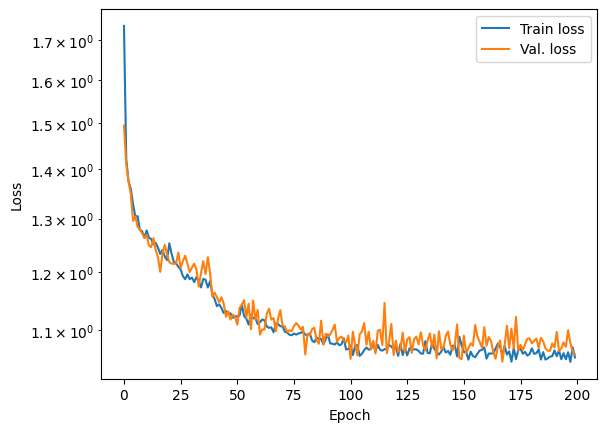

In [235]:
baseModel = TransformerModel(input_size=whiteFeatures.shape[1], output_size=len(classes), num_layers=5, num_heads=16, hidden_size=128, dropout=0.5)
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(baseModel.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=100, gamma=0.1)

device = torch.device("cpu")
# device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

nepoch = 200

train(baseModel, device, train_loader, optimiser, nepoch)

In [236]:
# print("Final training loss:  ", round(train_losses[-1], 4))
# print("Final validation loss:", round(val_losses[-1], 4))

In [237]:
# Testing the model on withheld white wine data.
acc = test(baseModel, device, test_loader)
print("Model Top-2 accuracy:", acc)

Model Top-2 accuracy: 85.71428571428571


In [238]:
# Printing model summary
import torchinfo
print(torchinfo.summary(baseModel, (64, 11), col_names = ("input_size", "output_size", "num_params")))

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
TransformerModel                              [64, 11]                  [64, 10]                  --
├─Linear: 1-1                                 [64, 11]                  [64, 128]                 1,536
├─TransformerEncoder: 1-2                     [64, 1, 128]              [64, 1, 128]              --
│    └─ModuleList: 2-1                        --                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [64, 1, 128]              [64, 1, 128]              99,584
│    │    └─TransformerEncoderLayer: 3-2      [64, 1, 128]              [64, 1, 128]              99,584
│    │    └─TransformerEncoderLayer: 3-3      [64, 1, 128]              [64, 1, 128]              99,584
│    │    └─TransformerEncoderLayer: 3-4      [64, 1, 128]              [64, 1, 128]              99,584
│    │    └─TransformerEncoderLayer: 3-5      [64, 1, 128]         

Computational Experiment 1: Testing model generalisability on red wine dataset.

In [241]:
# Testing the model on red wine data.
correct, total = 0, 0
baseModel.eval()

red_acc = test(baseModel, device, red_test_loader)
print("Model Top-2 accuracy:", red_acc)

Model Top-2 accuracy: 66.66666666666667
